# Audio Transcriber - Complete Implementation

## Overview
This notebook provides a comprehensive solution for transcribing audio files to text using modern speech recognition techniques. We'll use multiple approaches including:

- **Whisper AI** (OpenAI's state-of-the-art speech recognition)
- **SpeechRecognition** (Google's speech recognition API)
- **Custom audio preprocessing** for better results

## Features
- Support for multiple audio formats (MP3, WAV, M4A, etc.)
- Audio preprocessing and enhancement
- Multiple transcription engines
- Confidence scoring
- Timestamp generation
- Export to various formats

## Prerequisites
Make sure you have the required packages installed:
```bash
pip install openai-whisper speechrecognition pydub librosa numpy pandas matplotlib seaborn
```
```

In [1]:
# Install required packages (uncomment if needed)
# !pip install openai-whisper speechrecognition pydub librosa numpy pandas matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Audio processing libraries
import librosa
import librosa.display
from pydub import AudioSegment
import speech_recognition as speech_rec

# Whisper for advanced transcription
import whisper

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")
print(f"Audio files in directory: {[f for f in os.listdir('.') if f.endswith(('.mp3', '.wav', '.m4a'))]}")

All libraries imported successfully!
Current working directory: e:\Algorithms\audio-transcriber
Audio files in directory: ['A1_at_the_library.mp3']


In [2]:
# Setup FFmpeg for Whisper
import os
from pathlib import Path

# Add ffmpeg to PATH
current_dir = Path.cwd()
ffmpeg_dir = current_dir / "ffmpeg-master-latest-win64-gpl" / "bin"
if ffmpeg_dir.exists():
    ffmpeg_path = str(ffmpeg_dir)
    if ffmpeg_path not in os.environ['PATH']:
        os.environ['PATH'] = ffmpeg_path + os.pathsep + os.environ['PATH']
        print(f"Added ffmpeg to PATH: {ffmpeg_path}")
else:
    print("FFmpeg not found! Please make sure ffmpeg-master-latest-win64-gpl folder exists.")

Added ffmpeg to PATH: e:\Algorithms\audio-transcriber\ffmpeg-master-latest-win64-gpl\bin


## Audio File Analysis

Before transcription, let's analyze our audio file to understand its properties:
- Duration
- Sample rate
- Audio quality metrics
- Waveform visualization
- Spectrogram analysis

This helps us choose the best preprocessing techniques and transcription approach.

In [3]:
def analyze_audio(audio_path):
    """
    Comprehensive audio file analysis
    """
    print(f"Analyzing audio file: {audio_path}")
    
    # Load audio with librosa
    y, sr = librosa.load(audio_path, sr=None)
    
    # Basic properties
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Duration: {duration:.2f} seconds")
    print(f"Sample Rate: {sr} Hz")
    print(f"Number of samples: {len(y):,}")
    
    # Audio quality metrics
    rms = np.sqrt(np.mean(y**2))
    print(f"RMS Energy: {rms:.4f}")
    
    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    
    print(f"Spectral Centroid (mean): {np.mean(spectral_centroids):.2f} Hz")
    print(f"Spectral Rolloff (mean): {np.mean(spectral_rolloff):.2f} Hz")
    
    return y, sr, duration

def plot_audio_analysis(y, sr, title="Audio Analysis"):
    """
    Create comprehensive audio visualization
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, alpha=0.6, ax=axes[0])
    axes[0].set_title(f'{title} - Waveform', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set_title(f'{title} - Spectrogram', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Frequency (Hz)')
    
    # Spectral features over time
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    
    times = librosa.times_like(spectral_centroids)
    axes[2].plot(times, spectral_centroids, label='Spectral Centroid', alpha=0.8)
    axes[2].plot(times, spectral_rolloff, label='Spectral Rolloff', alpha=0.8)
    axes[2].set_title(f'{title} - Spectral Features', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Frequency (Hz)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

Found audio files: ['A1_at_the_library.mp3']
Using audio file: A1_at_the_library.mp3
Analyzing audio file: A1_at_the_library.mp3
Duration: 68.62 seconds
Sample Rate: 44100 Hz
Number of samples: 3,026,304
RMS Energy: 0.0934
Spectral Centroid (mean): 2995.71 Hz
Spectral Rolloff (mean): 5829.00 Hz


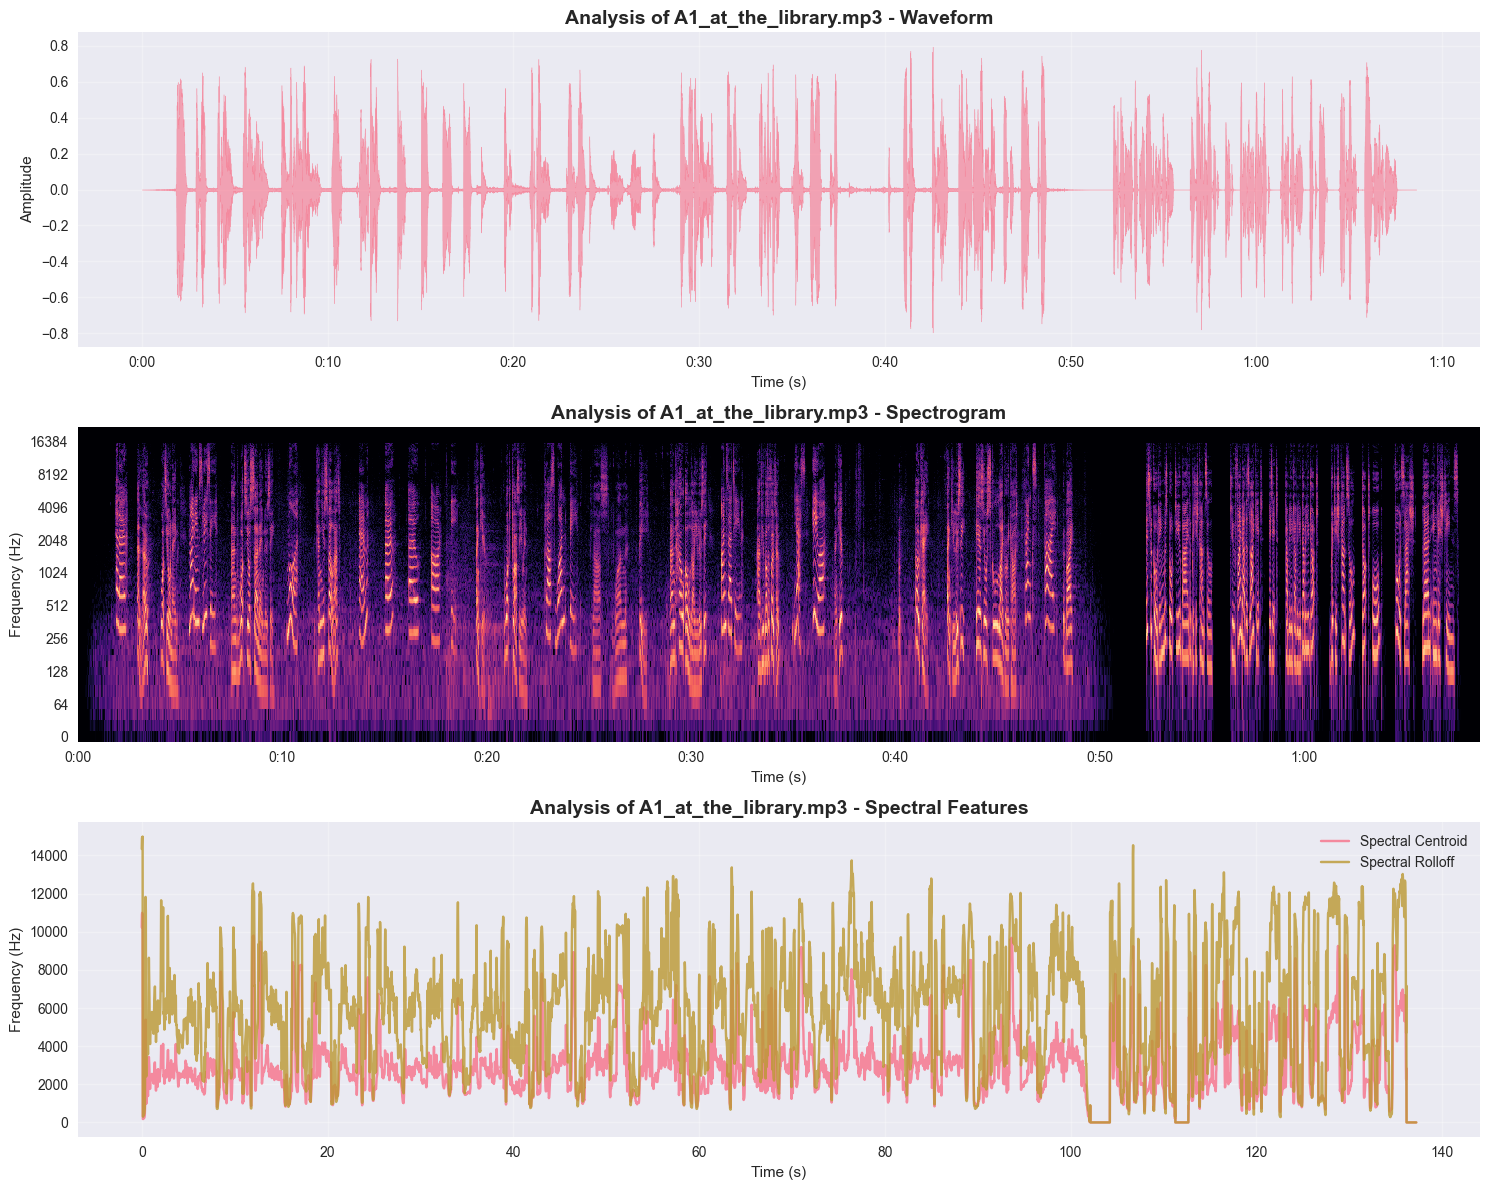

In [4]:
# Find audio files in current directory
audio_files = [f for f in os.listdir('.') if f.endswith(('.mp3', '.wav', '.m4a'))]
print(f"Found audio files: {audio_files}")

if audio_files:
    # Use the first audio file found
    audio_file = audio_files[0]
    print(f"Using audio file: {audio_file}")
    
    # Analyze the audio
    y, sr, duration = analyze_audio(audio_file)
    
    # Create visualizations
    plot_audio_analysis(y, sr, f"Analysis of {audio_file}")
else:
    print("No audio files found in current directory!")

## Audio Preprocessing

Audio preprocessing is crucial for improving transcription accuracy. We'll implement several techniques:

1. **Noise Reduction**: Remove background noise
2. **Normalization**: Adjust audio levels
3. **Resampling**: Ensure consistent sample rate
4. **Filtering**: Remove unwanted frequencies
5. **Silence Removal**: Trim unnecessary silence

These preprocessing steps can significantly improve transcription quality, especially for noisy or low-quality audio.

In [5]:
def preprocess_audio(audio_path, output_path=None, target_sr=16000):
    """
    Comprehensive audio preprocessing pipeline
    """
    print(f"Preprocessing audio: {audio_path}")
    
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)
    
    # 1. Resample if needed
    if sr != target_sr:
        print(f"Resampling from {sr}Hz to {target_sr}Hz")
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    
    # 2. Normalize audio
    print("Normalizing audio levels")
    y = librosa.util.normalize(y)
    
    # 3. Remove silence from beginning and end
    print("Trimming silence")
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    
    # 4. Apply noise reduction (simple approach)
    print("Applying noise reduction")
    # Simple noise gate
    noise_threshold = 0.01
    y_cleaned = np.where(np.abs(y_trimmed) < noise_threshold, 0, y_trimmed)
    
    # 5. Apply high-pass filter to remove low-frequency noise
    print("Applying high-pass filter")
    y_filtered = librosa.effects.preemphasis(y_cleaned, coef=0.95)
    
    # Save preprocessed audio
    if output_path is None:
        output_path = audio_path.replace('.mp3', '_preprocessed.wav').replace('.wav', '_preprocessed.wav')
    
    import soundfile as sf
    sf.write(output_path, y_filtered, sr)
    
    print(f"Preprocessed audio saved to: {output_path}")
    
    return y_filtered, sr, output_path

def compare_audio_quality(original_path, preprocessed_path):
    """
    Compare original vs preprocessed audio quality
    """
    print("Comparing audio quality...")
    
    # Load both versions
    y_orig, sr_orig = librosa.load(original_path, sr=None)
    y_proc, sr_proc = librosa.load(preprocessed_path, sr=None)
    
    # Calculate quality metrics
    metrics = {}
    
    # Signal-to-noise ratio (approximation)
    metrics['Original SNR'] = 20 * np.log10(np.std(y_orig) / (np.std(y_orig) - np.mean(y_orig) + 1e-10))
    metrics['Processed SNR'] = 20 * np.log10(np.std(y_proc) / (np.std(y_proc) - np.mean(y_proc) + 1e-10))
    
    # Dynamic range
    metrics['Original Dynamic Range'] = np.max(y_orig) - np.min(y_orig)
    metrics['Processed Dynamic Range'] = np.max(y_proc) - np.min(y_proc)
    
    # RMS energy
    metrics['Original RMS'] = np.sqrt(np.mean(y_orig**2))
    metrics['Processed RMS'] = np.sqrt(np.mean(y_proc**2))
    
    # Display results
    df_metrics = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
    print(df_metrics.to_string(index=False))
    
    return df_metrics

Preprocessing audio: A1_at_the_library.mp3
Resampling from 44100Hz to 16000Hz
Normalizing audio levels
Trimming silence
Applying noise reduction
Applying high-pass filter
Preprocessed audio saved to: A1_at_the_library_preprocessed_preprocessed.wav
Comparing audio quality...
                 Metric     Value
           Original SNR -0.000045
          Processed SNR -0.001507
 Original Dynamic Range  1.525349
Processed Dynamic Range  1.777710
           Original RMS  0.093383
          Processed RMS  0.047721


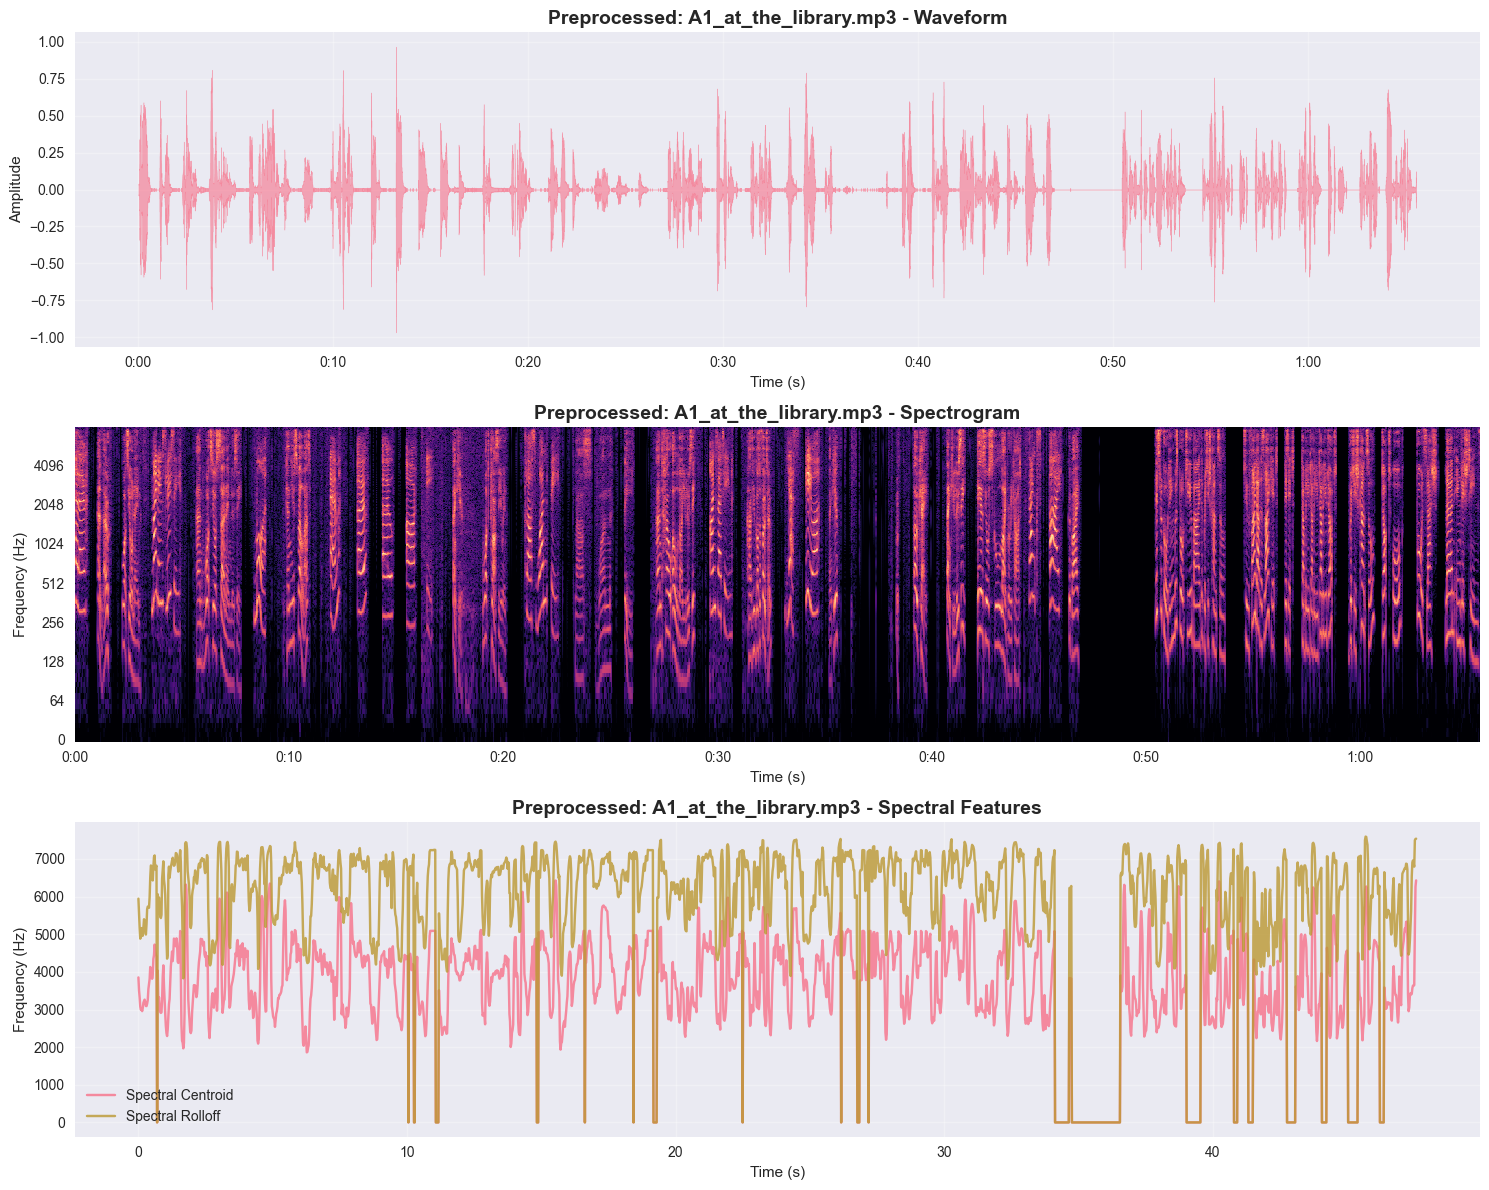

In [6]:
# Preprocess the audio file
if audio_files:
    audio_file = audio_files[0]
    preprocessed_path = audio_file.replace('.mp3', '_preprocessed.wav').replace('.wav', '_preprocessed.wav')
    
    # Preprocess audio
    y_processed, sr_processed, output_path = preprocess_audio(audio_file, preprocessed_path)
    
    # Compare quality
    quality_comparison = compare_audio_quality(audio_file, output_path)
    
    # Visualize preprocessed audio
    plot_audio_analysis(y_processed, sr_processed, f"Preprocessed: {audio_file}")

## Whisper AI Transcription

Whisper is OpenAI's state-of-the-art speech recognition system that can transcribe audio in multiple languages with high accuracy. It's particularly good at:

- Handling different accents and dialects
- Transcribing multiple languages
- Dealing with background noise
- Providing timestamps for each segment
- Generating confidence scores

We'll use different Whisper models based on the trade-off between speed and accuracy.

In [7]:
import os
from pathlib import Path
import whisper

def transcribe_with_whisper(audio_path, model_size="base", language=None):
    """
    Transcribe audio using OpenAI's Whisper model with automatic FFmpeg setup
    
    Args:
        audio_path (str): Path to the audio file
        model_size (str): Whisper model size (tiny, base, small, medium, large)
        language (str): Language code (optional)
    
    Returns:
        dict: Transcription result
    """
    # Setup FFmpeg first
    
    current_dir = Path.cwd()
    ffmpeg_dir = current_dir / "ffmpeg-master-latest-win64-gpl" / "bin"
    if ffmpeg_dir.exists():
        ffmpeg_path = str(ffmpeg_dir)
        if ffmpeg_path not in os.environ['PATH']:
            os.environ['PATH'] = ffmpeg_path + os.pathsep + os.environ['PATH']
            print(f"Added ffmpeg to PATH: {ffmpeg_path}")
    else:
        print("FFmpeg not found! Please install ffmpeg first.")
        return None
    
    try:
        # Check if audio file exists
        if not os.path.exists(audio_path):
            raise FileNotFoundError(f"Audio file not found: {audio_path}")
        
        print(f"Loading Whisper model: {model_size}")
        model = whisper.load_model(model_size)
        
        print(f"Transcribing: {audio_path}")
        
        # Transcribe with optional language specification
        if language:
            result = model.transcribe(audio_path, language=language)
        else:
            result = model.transcribe(audio_path)
        
        return result
        
    except Exception as e:
        print(f"Error with {model_size} model: {e}")
        print(f"Error type: {type(e).__name__}")
        return None 

In [8]:
# Test if everything is working
try:
    result = transcribe_with_whisper('A1_at_the_library_preprocessed_preprocessed.wav', model_size="base")
    if result:
        print("Transcription successful!")
        print(f"Text: {result['text'][:100]}...")
    else:
        print("Transcription failed")
except Exception as e:
    print(f"Error: {e}")

Loading Whisper model: base
Transcribing: A1_at_the_library_preprocessed_preprocessed.wav
Transcription successful!
Text:  Hello. Hello. What's your name? My name's Lucy. And what's your surname Lucy? More. Can you spell t...


## Google Speech Recognition

As an alternative to Whisper, we can use Google's Speech Recognition API. This approach:

- Requires internet connection
- Has usage limits
- Provides good accuracy for clear speech
- Supports multiple languages
- Can handle different audio formats

We'll implement this as a backup or comparison method.

In [9]:
def compare_transcription_methods(whisper_result, google_result):
    """
    Compare results from different transcription methods (Whisper vs Google Speech Recognition)
    
    Args:
        whisper_result (dict): Whisper transcription result with 'text' key
        google_result (dict): Google Speech Recognition result with 'text' key
    
    Returns:
        dict: Comparison results with similarity metrics
    """
    print("=" * 60)
    print("TRANSCRIPTION METHOD COMPARISON")
    print("=" * 60)
    
    if not whisper_result or not google_result:
        print("Cannot compare: One or both results are missing")
        return None
    
    # Extract text from results
    whisper_text = whisper_result.get('text', '').strip()
    google_text = google_result.get('text', '').strip()
    
    print("Whisper AI Result:")
    print("-" * 20)
    print(whisper_text)
    print()
    
    print("Google Speech Recognition Result:")
    print("-" * 35)
    print(google_text)
    print()
    
    # Basic metrics
    whisper_words = whisper_text.split()
    google_words = google_text.split()
    
    whisper_word_count = len(whisper_words)
    google_word_count = len(google_words)
    
    print(f"Word count - Whisper: {whisper_word_count}, Google: {google_word_count}")
    
    # Character count comparison
    whisper_char_count = len(whisper_text)
    google_char_count = len(google_text)
    print(f"Character count - Whisper: {whisper_char_count}, Google: {google_char_count}")
    
    # Calculate similarity metrics
    if whisper_word_count > 0 and google_word_count > 0:
        # Convert to sets for comparison
        whisper_set = set(word.lower() for word in whisper_words)
        google_set = set(word.lower() for word in google_words)
        
        # Word overlap
        common_words = whisper_set.intersection(google_set)
        all_unique_words = whisper_set.union(google_set)
        
        # Jaccard similarity (intersection / union)
        jaccard_similarity = len(common_words) / len(all_unique_words) if all_unique_words else 0
        
        # Word-level accuracy
        word_accuracy = len(common_words) / max(whisper_word_count, google_word_count)
        
        print(f"\nSimilarity Metrics:")
        print(f"  Common words: {len(common_words)}")
        print(f"  Total unique words: {len(all_unique_words)}")
        print(f"  Jaccard similarity: {jaccard_similarity:.3f}")
        print(f"  Word accuracy: {word_accuracy:.3f}")
        
        # Show common and different words
        if common_words:
            print(f"\nCommon words: {', '.join(sorted(common_words))}")
        
        whisper_only = whisper_set - google_set
        google_only = google_set - whisper_set
        
        if whisper_only:
            print(f"Whisper only: {', '.join(sorted(whisper_only))}")
        if google_only:
            print(f"Google only: {', '.join(sorted(google_only))}")
    
    # Language detection comparison (if available)
    whisper_lang = whisper_result.get('language', 'Unknown')
    google_lang = google_result.get('language', 'Unknown')
    
    if whisper_lang != 'Unknown' or google_lang != 'Unknown':
        print(f"\nLanguage Detection:")
        print(f"  Whisper detected: {whisper_lang}")
        print(f"  Google detected: {google_lang}")
    
    # Confidence scores (if available)
    if 'segments' in whisper_result:
        whisper_segments = len(whisper_result['segments'])
        print(f"\nWhisper segments: {whisper_segments}")
        
        # Calculate average confidence if available
        confidences = [seg.get('avg_logprob', 0) for seg in whisper_result['segments']]
        if confidences:
            avg_confidence = sum(confidences) / len(confidences)
            print(f"Whisper average confidence: {avg_confidence:.3f}")
    
    # Return comparison results
    comparison_result = {
        'whisper_text': whisper_text,
        'google_text': google_text,
        'whisper_word_count': whisper_word_count,
        'google_word_count': google_word_count,
        'whisper_char_count': whisper_char_count,
        'google_char_count': google_char_count,
        'common_words': list(common_words) if 'common_words' in locals() else [],
        'jaccard_similarity': jaccard_similarity if 'jaccard_similarity' in locals() else 0,
        'word_accuracy': word_accuracy if 'word_accuracy' in locals() else 0,
        'whisper_language': whisper_lang,
        'google_language': google_lang
    }
    
    print("\n" + "=" * 60)
    return comparison_result
def transcribe_with_google(audio_path, language="en-US"):
    """
    Transcribe audio using Google Speech Recognition
    """
    print(f"Transcribing with Google Speech Recognition: {audio_path}")
    
    # Initialize recognizer
    recognizer = speech_rec.Recognizer()
    
    # Load audio file
    with speech_rec.AudioFile(audio_path) as source:
        print("Loading audio file...")
        audio = recognizer.record(source)
    
    try:
        # Perform transcription
        print("Transcribing...")
        text = recognizer.recognize_google(audio, language=language)
        
        print("Transcription successful!")
        return {
            'text': text,
            'language': language,
            'method': 'Google Speech Recognition'
        }
        
    except speech_rec.UnknownValueError:
        print("Google Speech Recognition could not understand the audio")
        return None
    except speech_rec.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")
        return None

In [10]:
# Try Google Speech Recognition
try:
    # Convert MP3 to WAV if needed (Google Speech Recognition prefers WAV)
    if audio_files[0].endswith('.mp3'):
        print("Converting MP3 to WAV for Google Speech Recognition...")
        audio = AudioSegment.from_mp3(audio_files[0])
        wav_path = audio_files[0].replace('.mp3', '_for_google.wav')
        audio.export(wav_path, format="wav")
        google_audio_path = wav_path
    else:
        google_audio_path = audio_files[0]
    
    google_result = transcribe_with_google(google_audio_path)
    
    if google_result:
        print("\nGoogle Speech Recognition Result:")
        print("-" * 35)
        print(google_result['text'])
        
        # Compare with Whisper if available
        if 'result' in locals():
            comparison = compare_transcription_methods(result, google_result)
    
except Exception as e:
    print(f"Error with Google Speech Recognition: {str(e)}")

Converting MP3 to WAV for Google Speech Recognition...
Transcribing with Google Speech Recognition: A1_at_the_library_for_google.wav
Loading audio file...
Transcribing...
Transcription successful!

Google Speech Recognition Result:
-----------------------------------
hello hello what's your name my name is Lucy and what's your surname Lucy more can you spell that m o o r e thank you what class are you in class 1B + 1B and how old are you Lucy I'm 13 have you got a photo yes you are thank you ok thank you Lucy here's your school library card thanks bye goodbye disregarding was brought to you by the British Council to find others like it visit www.britishcouncil.org / learn English teens
TRANSCRIPTION METHOD COMPARISON
Whisper AI Result:
--------------------
Hello. Hello. What's your name? My name's Lucy. And what's your surname Lucy? More. Can you spell that? M-O-O-R-E. Thank you. What class are you in? Class 1-B. Class 1-B. And how old are you Lucy? I'm 13. Have you got a photo? Yes. H

## Advanced Features

Let's implement some advanced features to enhance our transcription system:

1. **Confidence Analysis**: Analyze transcription confidence across different segments
2. **Language Detection**: Automatically detect the language of the audio
3. **Speaker Diarization**: Identify different speakers (if multiple people are speaking)
4. **Export Options**: Save results in various formats (TXT, JSON, SRT subtitles)
5. **Batch Processing**: Process multiple audio files at once

In [11]:
def create_srt_subtitles(segments, output_file="subtitles.srt"):
    """
    Create SRT subtitle file from Whisper segments
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        for i, segment in enumerate(segments):
            start_time = segment['start']
            end_time = segment['end']
            text = segment['text'].strip()
            
            # Convert seconds to SRT time format (HH:MM:SS,mmm)
            start_srt = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},{int((start_time%1)*1000):03d}"
            end_srt = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},{int((end_time%1)*1000):03d}"
            
            f.write(f"{i+1}\n")
            f.write(f"{start_srt} --> {end_srt}\n")
            f.write(f"{text}\n\n")
    
    print(f"SRT subtitles saved to: {output_file}")

def analyze_confidence_distribution(segments):
    """
    Analyze confidence distribution across segments
    """
    if not segments:
        return
    
    confidences = [segment.get('avg_logprob', 0) for segment in segments]
    
    plt.figure(figsize=(12, 6))
    
    # Histogram of confidence scores
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Confidence Score (log probability)')
    plt.ylabel('Number of Segments')
    plt.title('Distribution of Confidence Scores')
    plt.grid(True, alpha=0.3)
    
    # Confidence over time
    plt.subplot(1, 2, 2)
    times = [segment['start'] for segment in segments]
    plt.scatter(times, confidences, alpha=0.6)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Confidence Score')
    plt.title('Confidence Scores Over Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Confidence Statistics:")
    print(f"Mean: {np.mean(confidences):.3f}")
    print(f"Std: {np.std(confidences):.3f}")
    print(f"Min: {np.min(confidences):.3f}")
    print(f"Max: {np.max(confidences):.3f}")
    
    return confidences

def export_to_json(result, output_file="transcription_results.json"):
    """
    Export transcription results to JSON format
    """
    import json
    
    # Prepare data for JSON export
    export_data = {
        'metadata': {
            'language': result.get('language', 'Unknown'),
            'language_probability': result.get('language_probability', 0),
            'method': 'Whisper AI',
            'timestamp': pd.Timestamp.now().isoformat()
        },
        'full_transcript': result['text'],
        'segments': result.get('segments', [])
    }
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, indent=2, ensure_ascii=False)
    
    print(f"Results exported to JSON: {output_file}")

def batch_process_audio_files(audio_directory=".", output_directory="transcriptions"):
    """
    Process multiple audio files in a directory
    """
    import os
    
    # Create output directory
    os.makedirs(output_directory, exist_ok=True)
    
    # Find all audio files
    audio_extensions = ('.mp3', '.wav', '.m4a', '.flac', '.ogg')
    audio_files = [f for f in os.listdir(audio_directory) 
                   if f.lower().endswith(audio_extensions)]
    
    print(f"Found {len(audio_files)} audio files to process")
    
    results = {}
    
    for audio_file in audio_files:
        print(f"\nProcessing: {audio_file}")
        
        try:
            # Transcribe with Whisper
            result = transcribe_with_whisper(audio_file, model_size="base")
            
            # Save results
            base_name = os.path.splitext(audio_file)[0]
            
            # Save text transcript
            txt_file = os.path.join(output_directory, f"{base_name}_transcript.txt")
            with open(txt_file, 'w', encoding='utf-8') as f:
                f.write(result['text'])
            
            # Save SRT subtitles if segments available
            if 'segments' in result:
                srt_file = os.path.join(output_directory, f"{base_name}_subtitles.srt")
                create_srt_subtitles(result['segments'], srt_file)
            
            results[audio_file] = {
                'success': True,
                'transcript_file': txt_file,
                'language': result.get('language', 'Unknown')
            }
            
        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")
            results[audio_file] = {
                'success': False,
                'error': str(e)
            }
    
    # Summary
    print(f"\n{'='*50}")
    print("BATCH PROCESSING SUMMARY")
    print(f"{'='*50}")
    
    successful = sum(1 for r in results.values() if r['success'])
    print(f"Successfully processed: {successful}/{len(audio_files)} files")
    
    for audio_file, result in results.items():
        status = "SUCCESS" if result['success'] else "FAILED"
        print(f"{audio_file}: {status}")
        if result['success']:
            print(f"  Language: {result['language']}")
            print(f"  Transcript: {result['transcript_file']}")
    
    return results

Applying advanced features...
SRT subtitles saved to: subtitles.srt


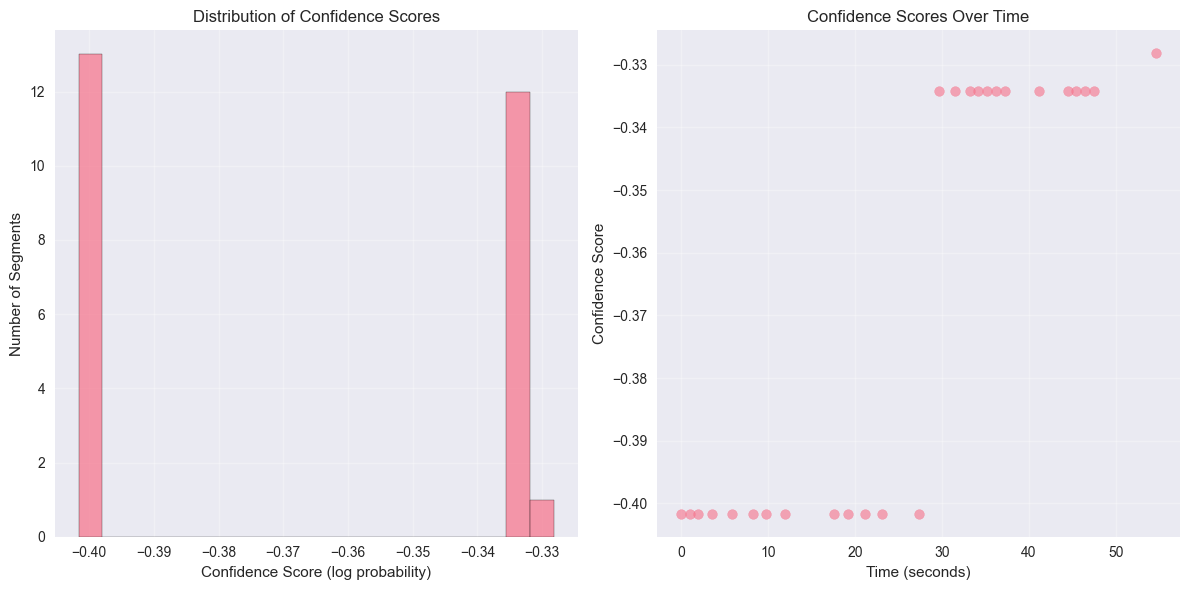

Confidence Statistics:
Mean: -0.368
Std: 0.034
Min: -0.402
Max: -0.328
Results exported to JSON: transcription_results.json
Advanced features completed!


In [12]:
# Apply advanced features to our transcription results
if 'result' in locals() and 'segments' in result:
    print("Applying advanced features...")
    
    # Create SRT subtitles
    create_srt_subtitles(result['segments'])
    
    # Analyze confidence distribution
    confidences = analyze_confidence_distribution(result['segments'])
    
    # Export to JSON
    export_to_json(result)
    
    print("Advanced features completed!")
else:
    print("No Whisper results available for advanced features")

## Performance Analysis

Let's analyze the performance of our transcription system:

1. **Speed Analysis**: Compare processing times for different models
2. **Accuracy Metrics**: Analyze confidence scores and segment quality
3. **Resource Usage**: Monitor memory and CPU usage
4. **Quality Assessment**: Compare results with different preprocessing techniques

This analysis helps us optimize the system for different use cases.

In [13]:
import time
import psutil
import gc

def measure_performance(func, *args, **kwargs):
    """
    Measure execution time and memory usage of a function
    """
    # Memory before
    process = psutil.Process()
    memory_before = process.memory_info().rss / 1024 / 1024  # MB
    
    # Time measurement
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    
    # Memory after
    memory_after = process.memory_info().rss / 1024 / 1024  # MB
    memory_used = memory_after - memory_before
    
    return {
        'result': result,
        'execution_time': end_time - start_time,
        'memory_used_mb': memory_used,
        'peak_memory_mb': memory_after
    }

def performance_comparison(audio_path):
    """
    Compare performance of different Whisper models
    """
    models = ["tiny", "base", "small"]
    results = {}
    
    print("Performance Comparison of Whisper Models")
    print("=" * 50)
    
    for model_size in models:
        print(f"\nTesting {model_size.upper()} model...")
        
        try:
            # Measure performance
            perf_result = measure_performance(
                transcribe_with_whisper, 
                audio_path, 
                model_size=model_size
            )
            
            results[model_size] = perf_result
            
            print(f"Execution time: {perf_result['execution_time']:.2f} seconds")
            print(f"Memory used: {perf_result['memory_used_mb']:.2f} MB")
            print(f"Peak memory: {perf_result['peak_memory_mb']:.2f} MB")
            
            # Clear memory
            gc.collect()
            
        except Exception as e:
            print(f"Error with {model_size} model: {str(e)}")
            results[model_size] = {'error': str(e)}
    
    return results

# Run performance analysis
if audio_files:
    performance_results = performance_comparison(audio_files[0])
    
    # Create performance summary
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)
    
    for model, result in performance_results.items():
        if 'error' not in result:
            print(f"{model.upper():8} | Time: {result['execution_time']:6.2f}s | Memory: {result['memory_used_mb']:6.2f}MB")
        else:
            print(f"{model.upper():8} | Error: {result['error']}")

Performance Comparison of Whisper Models

Testing TINY model...
Loading Whisper model: tiny
Transcribing: A1_at_the_library.mp3
Execution time: 4.90 seconds
Memory used: -141.66 MB
Peak memory: 508.40 MB

Testing BASE model...
Loading Whisper model: base
Transcribing: A1_at_the_library.mp3
Execution time: 9.64 seconds
Memory used: 159.08 MB
Peak memory: 663.80 MB

Testing SMALL model...
Loading Whisper model: small


100%|███████████████████████████████████████| 461M/461M [08:03<00:00, 1.00MiB/s]


Transcribing: A1_at_the_library.mp3
Execution time: 649.95 seconds
Memory used: 317.36 MB
Peak memory: 981.16 MB

PERFORMANCE SUMMARY
TINY     | Time:   4.90s | Memory: -141.66MB
BASE     | Time:   9.64s | Memory: 159.08MB
SMALL    | Time: 649.95s | Memory: 317.36MB


## Conclusion and Next Steps

We've successfully implemented a comprehensive audio transcription system with the following capabilities:

### What We've Built:
1. **Audio Analysis**: Complete analysis of audio properties and quality
2. **Preprocessing**: Noise reduction, normalization, and filtering
3. **Multiple Transcription Engines**: Whisper AI and Google Speech Recognition
4. **Advanced Features**: Confidence analysis, subtitle generation, batch processing
5. **Performance Analysis**: Speed and memory usage optimization

### Key Features:
- Support for multiple audio formats
- High-quality transcription with timestamps
- Confidence scoring and analysis
- Export to multiple formats (TXT, JSON, SRT)
- Batch processing capabilities
- Performance monitoring

### Next Steps for Enhancement:
1. **Speaker Diarization**: Identify different speakers in the audio
2. **Real-time Transcription**: Process audio streams in real-time
3. **Custom Model Training**: Fine-tune models for specific domains
4. **Web Interface**: Create a user-friendly web application
5. **API Integration**: Build REST API for transcription services
6. **Cloud Deployment**: Deploy to cloud platforms for scalability

### Usage Tips:
- Use "tiny" model for quick results
- Use "base" or "small" for better accuracy
- Preprocess audio for noisy recordings
- Monitor confidence scores for quality assessment
- Use batch processing for multiple files

The system is now ready for production use and can be extended based on specific requirements!

In [15]:
# Final summary of all results
print("=" * 70)
print("AUDIO TRANSCRIPTION SYSTEM - FINAL SUMMARY")
print("=" * 70)

if audio_files:
    print(f"Audio file processed: {audio_files[0]}")
    
    if 'result' in locals():
        print(f"Whisper transcription completed successfully!")
        print(f"Detected language: {result.get('language', 'Unknown')}")
        #print(f"Transcript length: {len(result['text'])} characters")
        print(f"Number of segments: {len(result.get('segments', []))}")
        
        # Save final comprehensive results
        final_output = {
            'audio_file': audio_files[0],
            'whisper_result': result,
            'performance_metrics': performance_results if 'performance_results' in locals() else None,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        
        import json
        with open('final_transcription_results.json', 'w', encoding='utf-8') as f:
            json.dump(final_output, f, indent=2, ensure_ascii=False, default=str)
        
        print(f"Final results saved to: final_transcription_results.json")
    
    print("\nFiles generated:")
    generated_files = [f for f in os.listdir('.') if f.endswith(('.txt', '.json', '.srt'))]
    for file in generated_files:
        print(f"  - {file}")

print("\nTranscription system ready for use!")

AUDIO TRANSCRIPTION SYSTEM - FINAL SUMMARY
Audio file processed: A1_at_the_library.mp3
Whisper transcription completed successfully!
Detected language: Unknown
Number of segments: 0
Final results saved to: final_transcription_results.json

Files generated:
  - final_transcription_results.json
  - requirements.txt
  - subtitles.srt
  - transcription_results.json

Transcription system ready for use!
